# Linear regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

np.random.seed(1234)
mkl.set_num_threads(2)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

## Useful imports

In [2]:
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm as normal_dist
from numpy.linalg import inv

## Useful utility functions

In [3]:
# Plot 'iso-densities' for MVN
#   ax - axis for plotting,
#   mu, Sigma - MVN parameters,
#   title - plot title.
def plot_mvn(ax, mu, Sigma, title = None, grid_size = 100):
    mu = np.squeeze(mu)
    mu_x, mu_y = mu[0], mu[1]
    s_x, s_y = np.sqrt(Sigma[0, 0]), np.sqrt(Sigma[1, 1])
    
    xmin, xmax = mu_x-3*s_x, mu_x+3*s_x
    ymin, ymax = mu_y-3*s_y, mu_y+3*s_y
    
    X = np.linspace(xmin, xmax, grid_size)
    Y = np.linspace(ymin, ymax, grid_size)
    X, Y = np.meshgrid(X, Y)
    grid = np.vstack([X.flatten(), Y.flatten()]).T
    
    p = mvn(mu, Sigma)
    density = p.pdf(grid).reshape((grid_size, grid_size))

    ax.contour(X, Y, density, zorder=1)
    
    if title is not None:
        ax.set_title(title)
    
    plt.show

In [4]:
# Plot a linear regression fit
#   ax - axis for plotting,
#   w - linear regression parameters
#   data_x, data_y, data_ys - explanatory variables, responses and their uncertainties (data)
#   test_x, test_y, test_ys - explanatory variables, predictions and their uncertainties (test)
#   RSS - residual  sum of squares
#   title - plot title.
def plot_fit(ax, w, data_x, data_y, data_ys, 
             test_x=None, test_y=None, test_ys=None,
             RSS=None, title=None):
    xmin, xmax = np.min(data_x[:, 0]), np.max(data_x[:, 0])
    if test_x is not None:
        test_min, test_max = np.min(test_x[:, 0]), np.max(test_x[:, 0])
        xmin = min(xmin, test_min)
        xmax = max(xmax, test_max)
    
    X = np.array([[xmin, 1], [xmax, 1]])
    y = X @ w
    
    ax.errorbar(data_x[:, 0], data_y[:, 0], data_ys, None, marker="o", ls='', capsize=5)
    if test_x is not None:
        ax.errorbar(test_x[:, 0], test_y, test_ys, None, marker="x", c='g', ls='', capsize=5);
    
    ax.plot(X[:, 0], y, marker='', lw=2.0, color='r');
    
    ax.set_xlabel('x', fontsize='xx-large')
    ax.set_ylabel('y', fontsize='xx-large')
    if RSS is not None:
        ax.text(0.95, 0.01, 'Residual sum of squares: {0:0.1f}'.format(RSS),
                verticalalignment='bottom', horizontalalignment='right',
                transform=ax.transAxes, fontsize=15)
    
    if title is not None:
        ax.set_title(title)

In [5]:
# Plot samples from a Bayesian linear regression
#   ax - axis for plotting,
#   w_samples - samples from the posterior over regression parameters
#   data_x, data_y, data_ys - explanatory variables, responses and their uncertainties (data)
#   title - plot title.
def plot_posterior_samples(ax, w_samples, data_x, data_y, data_ys, title=None):
    ax.errorbar(data_x[:, 0], data_y[:, 0], data_ys, None, marker="o", ls='', capsize=5)
    ax.set_xlabel('x', fontsize='xx-large')
    ax.set_ylabel('y', fontsize='xx-large')

    xmin, xmax = np.min(data_x[:, 0]), np.max(data_x[:, 0])
    X = np.array([[xmin, 1], [xmax, 1]])
    
    for w in w_samples:
        y = X @ w
        ax.plot(X[:, 0], y, marker='', lw=1.0, alpha=0.5, color='r');
    
    if title is not None:
        ax.set_title(title)

## Regression data

In [6]:
# D.W. Hogg et al. Data analysis recipes: Fitting a model to data, https://arxiv.org/abs/1008.4686, 2010
hogg_data = np.array([[201, 592, 61],
                      [244, 401, 25],
                      [47, 583, 38],
                      [287, 402, 15],
                      [203, 495, 21],
                      [58, 173, 15],
                      [210, 479, 27],
                      [202, 504, 14],
                      [198, 510, 30],
                      [158, 416, 16],
                      [165, 393, 14],
                      [201, 442, 25],
                      [157, 317, 52],
                      [131, 311, 16],
                      [166, 400, 34],
                      [160, 337, 31],
                      [186, 423, 42],
                      [125, 334, 26],
                      [218, 533, 16],
                      [146, 344, 22]], dtype=np.float32)

Formally, our model is:

$y = \mathbf{w}^\mathsf{T}\mathbf{x} + b + \epsilon$

However, we can get rid of the bias term $b$ by appending 1s to the explanatory variables and including $b$ in $w$:

$
\mathbf{x} \leftarrow [\mathbf{x}, 1] \\
\mathbf{w} \leftarrow [\mathbf{w}, b]
$

Then our model becomes:

$y = \mathbf{w}^\mathsf{T}\mathbf{x} + \epsilon$

Now, lets pack all explanatory variables to a single matrix $\mathbf{X}$ (each row of $\mathbf{X}$ is a vector of explanatory variables for a single observation). We will then have a following model:

$\mathbf{y} = \mathbf{X}\mathbf{w} + \boldsymbol \epsilon$

Let's prepare our data for this model.

In [7]:
hogg_x, hogg_y, hogg_ys = hogg_data[:, 0], hogg_data[:, 1], hogg_data[:, 2]

# ys - niepewność zmiennych objaśnianych

hogg_x, hogg_y = hogg_x[:, None], hogg_y[:, None]

ones = np.ones((hogg_x.shape[0], 1))
hogg_x = np.concatenate((hogg_x, ones), axis=1)

In [8]:
print('explanatory variable:')
for x1, x2 in hogg_x[:3, :]:  
       print('{0}\t{1:.1f}'.format(x1, x2))
print('...')

print('\nresponses:')
for y in hogg_y[:3]:  
       print('{0}'.format(y[0]))
print('...')

explanatory variable:
201.0	1.0
244.0	1.0
47.0	1.0
...

responses:
592.0
401.0
583.0
...


---

Now, let's plot this data.

Text(0, 0.5, 'y')

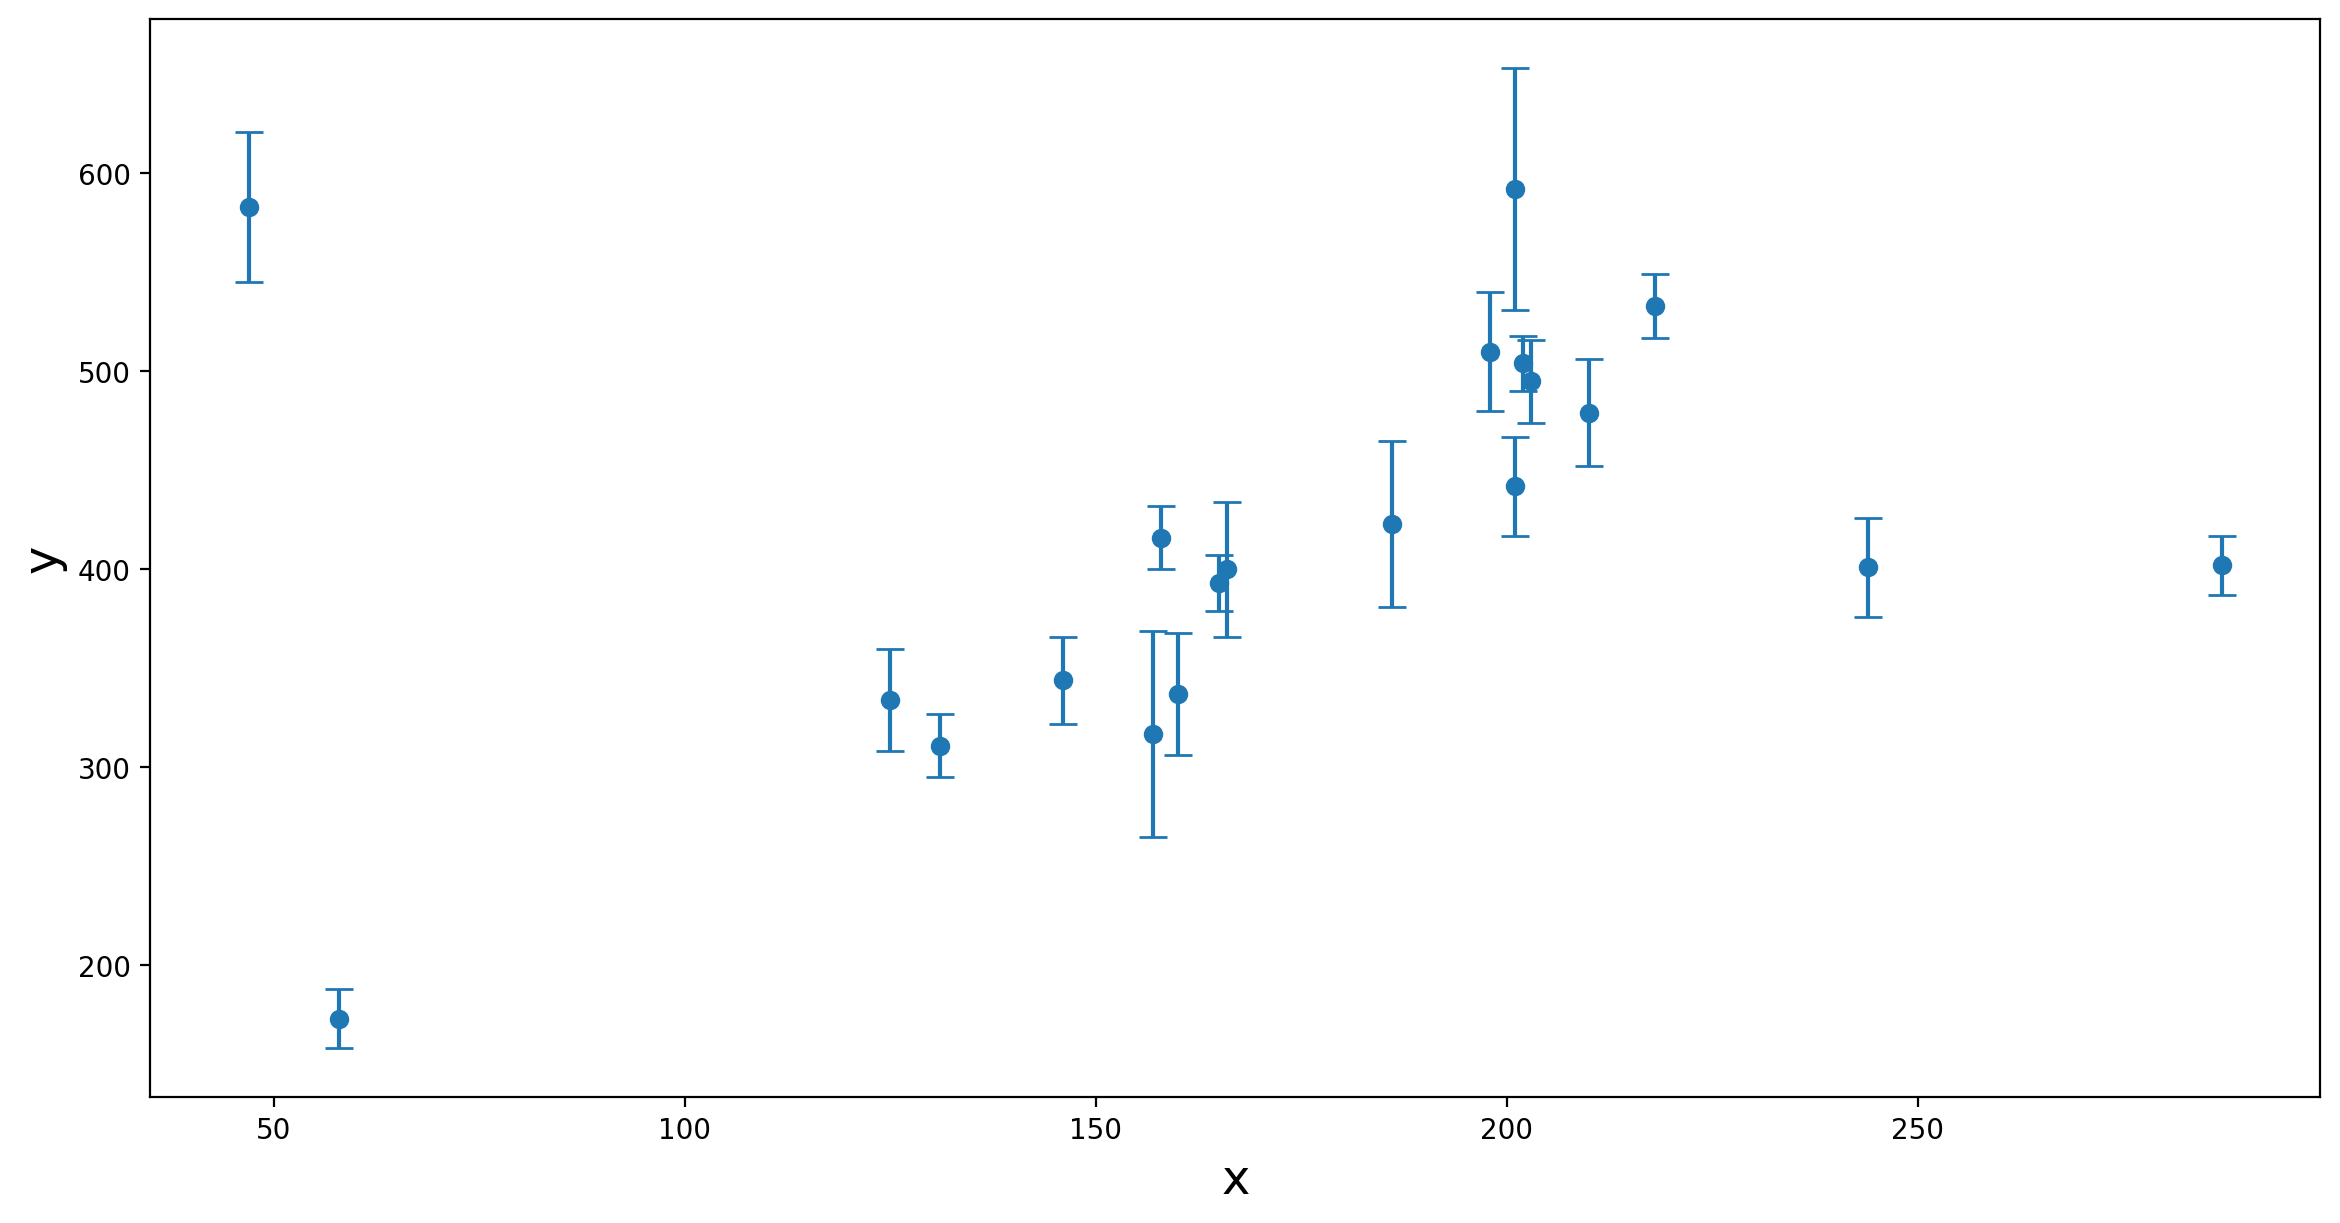

In [9]:
fig = plt.figure(figsize=(14, 7))
plt.errorbar(hogg_x[:, 0], hogg_y[:, 0], hogg_ys, None, marker="o", ls='', capsize=5)
plt.xlabel('x', fontsize='xx-large')
plt.ylabel('y', fontsize='xx-large')

## Ordinary least squares fit

Our first task is to calculate an ordinary least squares fit to ``hogg_data``.

Implement the `OLS` function, which:
- takes as an input a matrix of explanatory variables and a vector of responses
- and returns:
  - maximum likelihood estimation of a linear regression fit to this data (i.e. OLS solution),
  - residual sum of squares, i.e. $\sum_{i=1}^n (y_i - \mathbf{w}^\mathsf{T}\mathbf{x}_i)^2 = (\mathbf{y} - \mathbf{X}\mathbf{w})^\mathsf{T} (\mathbf{y} - \mathbf{X}\mathbf{w})$.

In [10]:
def OLS(X : np.array, y : np.array):
    w = inv(X.T @ X) @ X.T @ y
    RSS = (y - X @ w).T @ (y - X @ w)
    
    return w, RSS.item()

Now we can calculate and plot an OLS fit. <br>
Ordinary least squares disregards uncertainties in response variables, so we do not plot error bars.

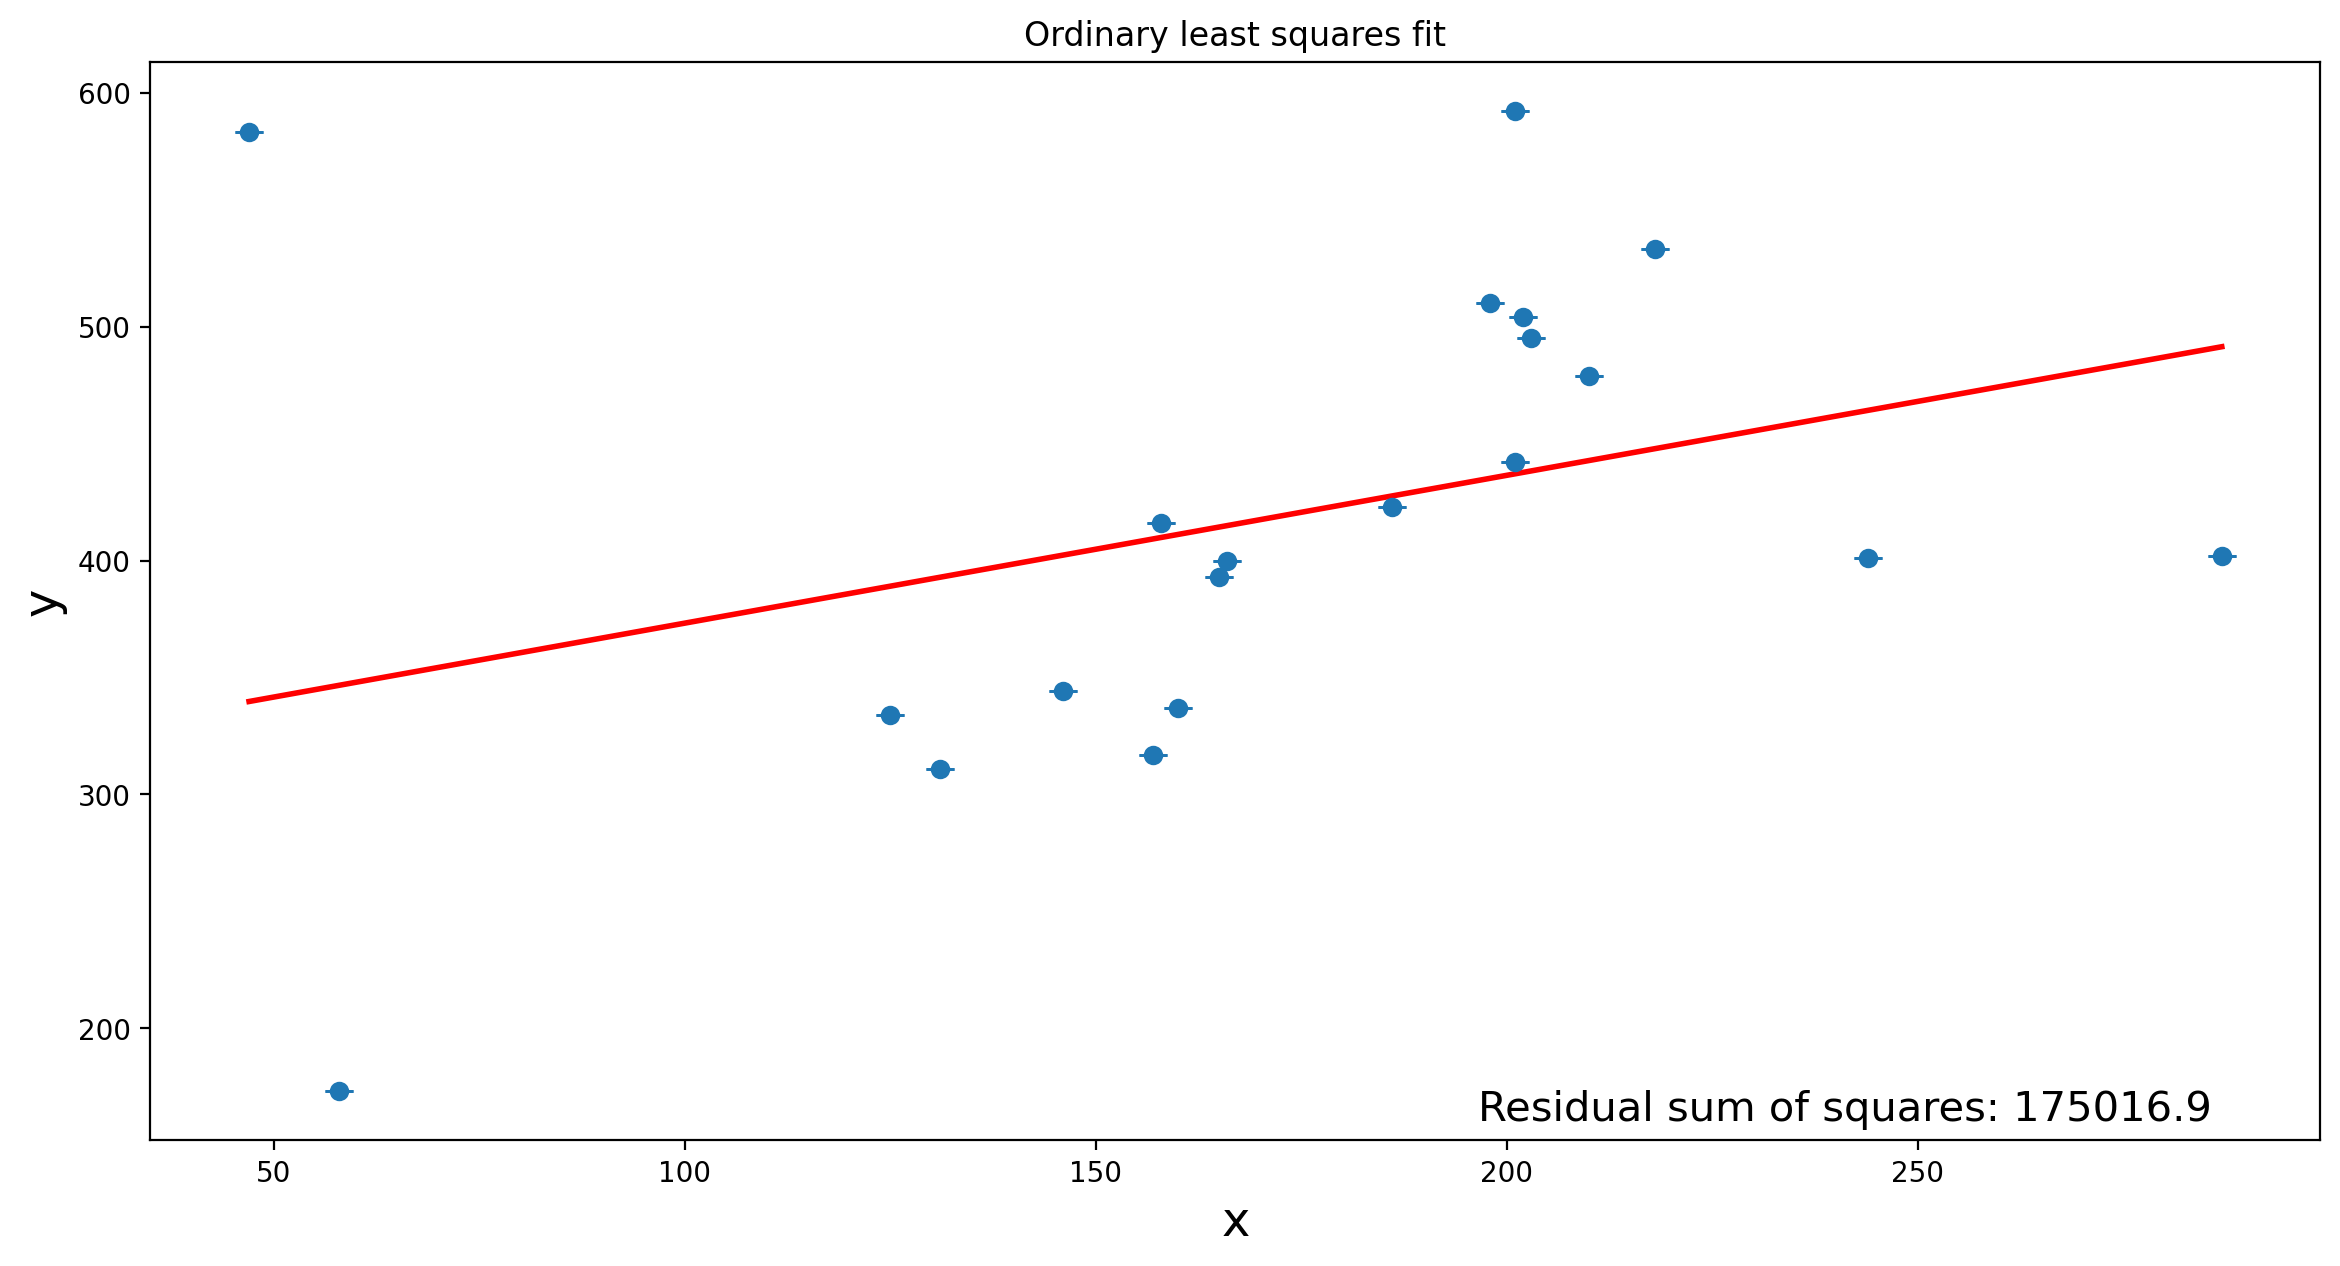

In [11]:
w, RSS = OLS(hogg_x, hogg_y)

fig = plt.figure(figsize=(14, 7))
plot_fit(plt.gca(), w, hogg_x, hogg_y, 0, RSS=RSS, title='Ordinary least squares fit')

Is this a convincing fit?

It could be better (because of the outliers).

## Bayesian linear regression

To gain insight into uncertainty of our fit, we must move to Bayesian modeling.

Implement `bayes_lin_reg` function, which:
- takes as an input:
    - prior mean and covariance of the regression parameters $\mathbf{w}$,
    - response uncertainty ($\sigma$ hyperparameter),
    - matrix of explanatory variables and vector of responses,
- and returns parameters of the posterior distribution over $\mathbf{w}$ (mean and covariance).

In [12]:
def bayes_lin_reg(prior_mu, prior_Sigma, sigma, X, y):
    inv_prior_Sigma = inv(prior_Sigma)
    inv_sigma_sq = 1 / (sigma ** 2)

    Sigma = inv(inv_prior_Sigma + inv_sigma_sq * X.T @ X)
    mu = Sigma @ (inv_sigma_sq * X.T @ y + inv_prior_Sigma @ prior_mu)

    return mu, Sigma

Now we need to propose a reasonable prior for $\mathbf{w}$.

Propose and justify (in a comment) mean and covariance for the prior distribution over $\mathbf{w}$. You can use an informative prior.

<div style="max-width:900px; margin: 0 auto; text-align: left;">
    
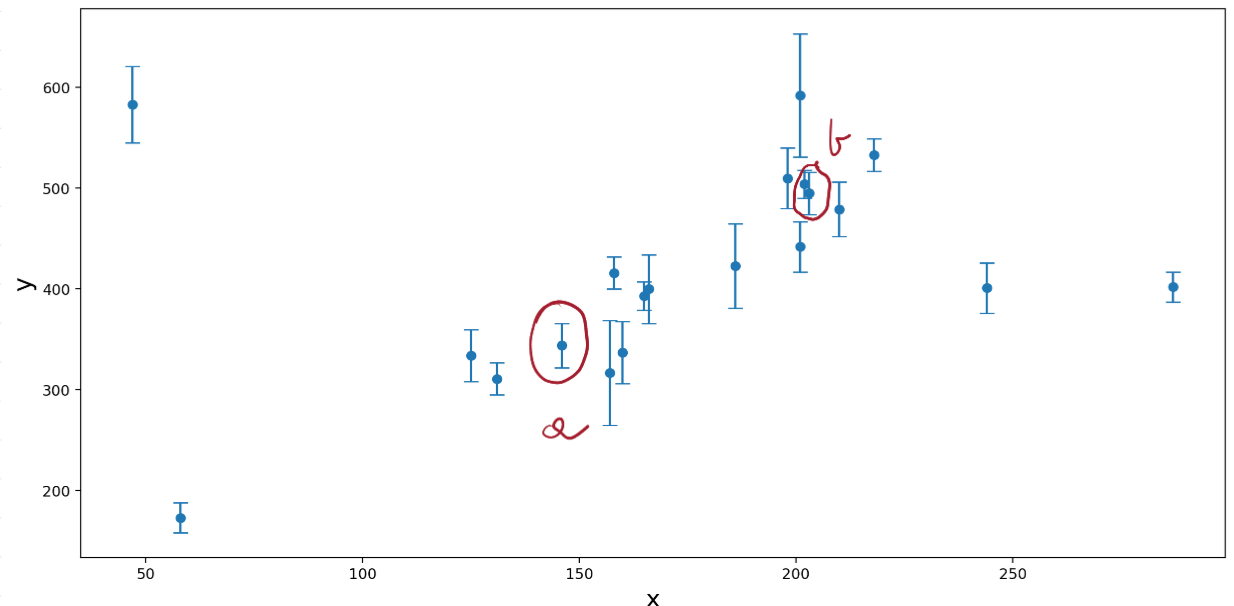
    
</div>

Points `a` and `b` lie on the straight line that I consider the best fit. I'll use them to calculate prior values of slope and intercept: $\mathbf{w} = [\mathbf{w}, b]$. Nevertheless, without reading their coordinates, I'd choose the scope as two and intercept near -50 (intuitively).

Prior covariance matrix looks like that:

$$\Sigma_{\mathbf{0}} = \begin{bmatrix} \sigma_w^2 & 0 \\ 0 & \sigma_b^2 \end{bmatrix}$$

Based on the plot we can assume that standard deviation of the slope is no more than $2$, thus $\sigma_w^2 = 4$. 

Standard deviation of the intercept is slightly connected with $\sigma_y$, as they are in the same dimension ($y$). By moving the line up and down at a particular point, the value changes along the lines of the deviation, which could be similar to $b$. Knowing this, we can assume $\sigma_b$ as an average of the data deviation ($\sigma_y$).

In [13]:
# raise Exception('Propose and justify (in a comment) mean and covariance for the prior distribution over w')

a = (146, 344) # first point
b = (203, 495) # second point

slope = (b[1] - a[1]) / (b[0] - a[0])
intercept = a[1] - slope * a[0]

mu_0 = np.array([slope, intercept]).reshape((-1, 1))
# [w, b] vector

Sigma_0 = np.array([
    [2**2, 0],
    [0, np.average(hogg_ys) ** 2]
])

### Posterior distributions

We are now ready to calculate posterior distributions over parameters of our linear regression fits.

To gain an insight into behavior of these posteriors, we will plot:
- Prior.
- Posterior after observing just one data point. <br>
  <u>Look at the distribution of the regression slope (when we know just one data point). Write your conclusions about this distribution in a comment below the plots</u>.
- Posterior after observing 5 data points.
- Posterior after observing all data points.

<u>Why these posteriors are oriented "diagonally". Answer in a comment below the plots</u>.

In [14]:
def plot_posteriors():
    mu_1, Sigma_1 = bayes_lin_reg(mu_0, Sigma_0, sigma, hogg_x[:1], hogg_y[:1])
    mu_10, Sigma_10 = bayes_lin_reg(mu_1, Sigma_1, sigma, hogg_x[1:10], hogg_y[1:10])
    mu_n, Sigma_n = bayes_lin_reg(mu_10, Sigma_10, sigma, hogg_x[10:], hogg_y[10:])
    
    _, ax = plt.subplots(2, 2, figsize=(8,8))
    plot_mvn(ax[0, 0], mu_0, Sigma_0, title='Prior')
    plot_mvn(ax[0, 1], mu_1, Sigma_1, title='Posterior after 1 observation')
    plot_mvn(ax[1, 0], mu_10, Sigma_10, title='Posterior after 10 observations')
    plot_mvn(ax[1, 1], mu_n, Sigma_n, title='Posterior after all observations')

We start with posteriors when response uncertainty $\sigma = 25.0$

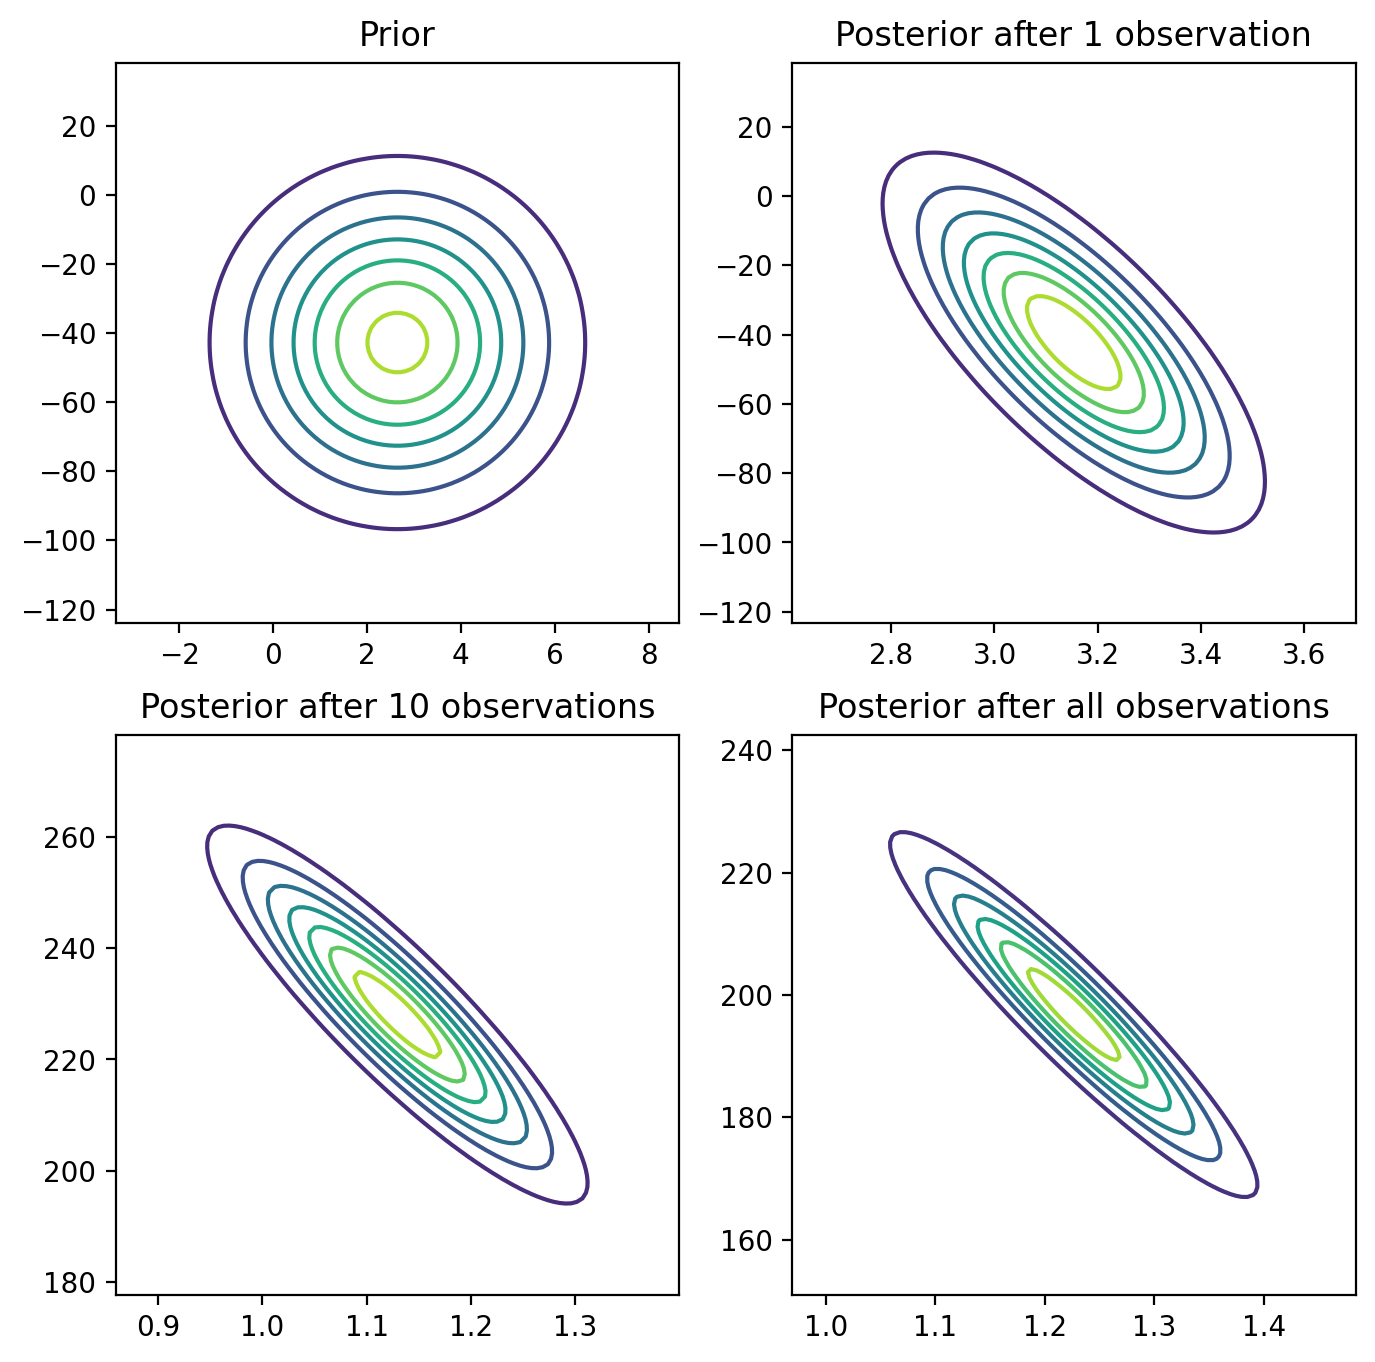

In [15]:
sigma = 25.

plot_posteriors()

Let's see what happens when response uncertainty increases to $\sigma = 100.0$

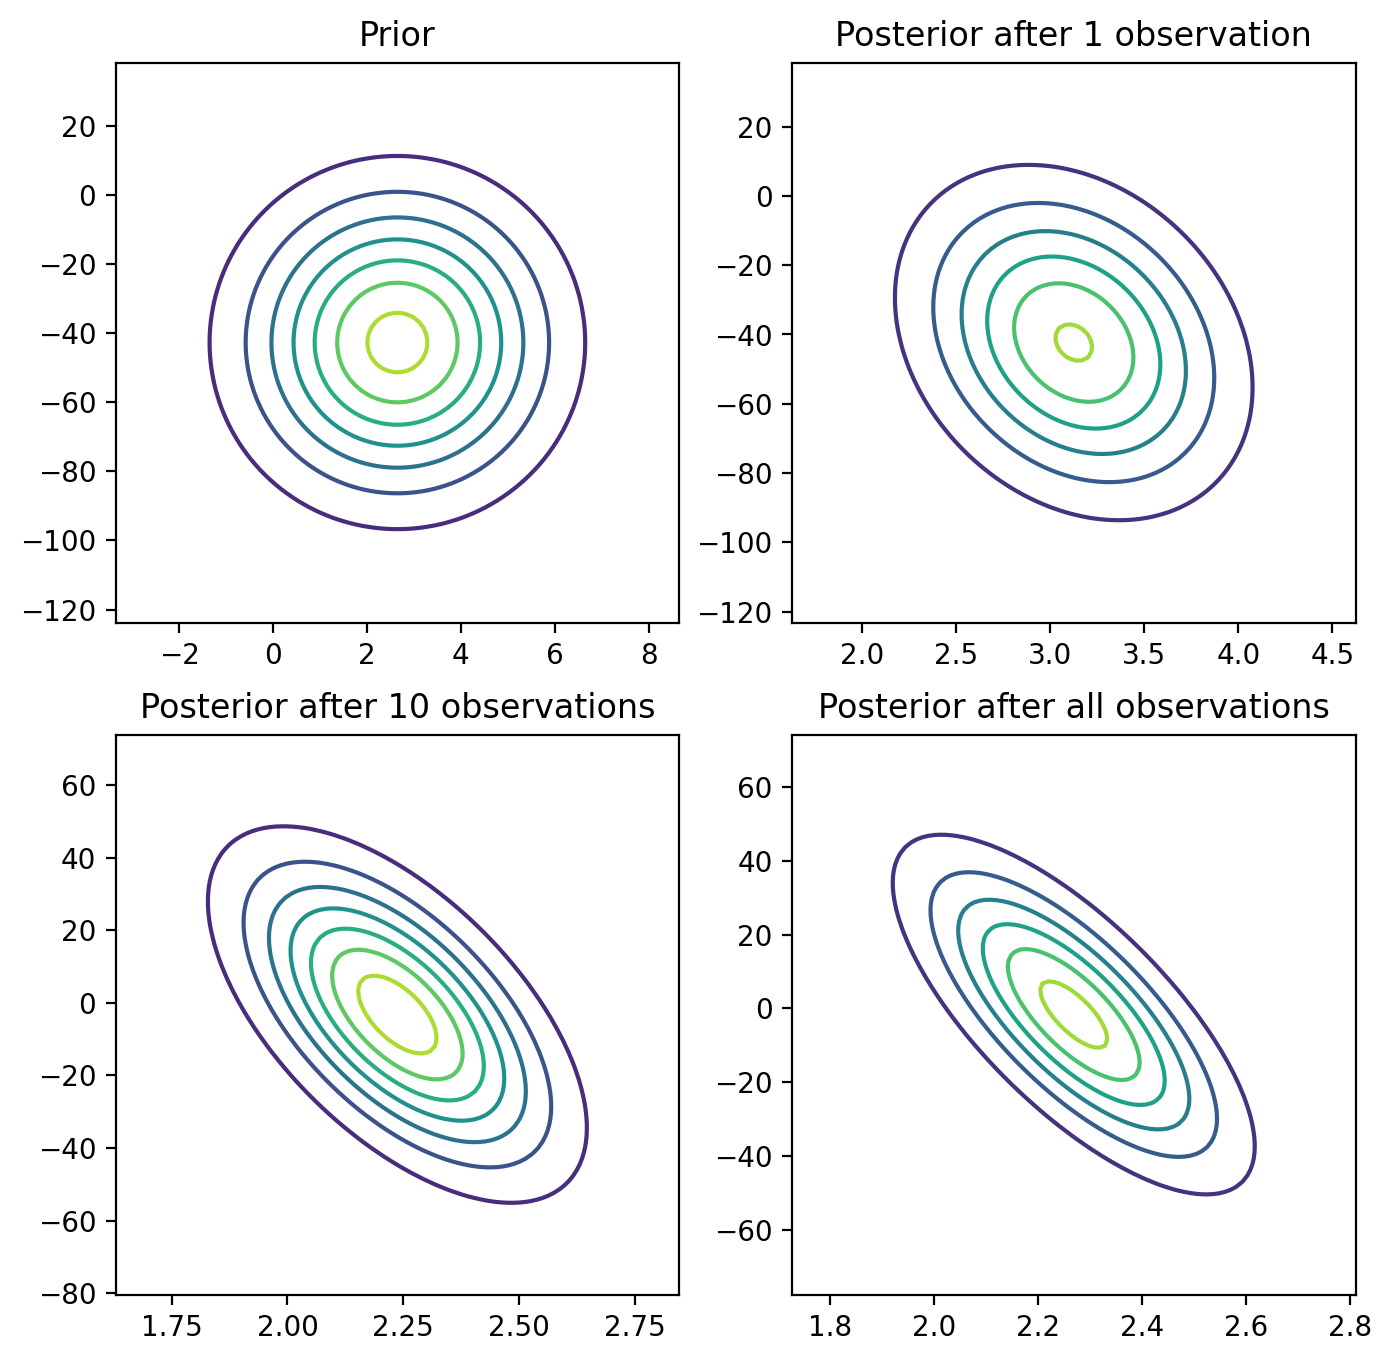

In [16]:
sigma = 100.

plot_posteriors()

### Answers

1. Look at the distribution of the regression slope (when we know just one data point). Write your conclusions about this distribution in a comment below the plots.

- The posterior distribution of the regression slope after just one observation is stretched and highly uncertain. Compared to the prior, it is no longer circular but has become an ellipse, indicating that some information about the slope has been gained. However, the distribution remains wide, reflecting high variance — this means that with only one data point, the model still has a lot of uncertainty about the actual slope.

2. Why these posteriors are oriented "diagonally"?

- The posteriors are oriented diagonally because the slope and intercept of a linear regression model are correlated.
If the intercept is slightly overestimated, the slope tends to be underestimated, and vice versa.
This creates an elliptical posterior distribution where uncertainty along one axis (slope) depends on the other (intercept).
As more observations are collected, this correlation remains but the uncertainty decreases, making the posterior distribution more concentrated around the true values.

### MAP fit

Let's try another point estimate for $\mathbf{w}$ - maximum a posteriori estimate.

First, we calculate a posterior distribution:

In [17]:
sigma = 25.

mu_n, Sigma_n = bayes_lin_reg(mu_0, Sigma_0, sigma, hogg_x, hogg_y)

Now, find the MAP estimate for $\mathbf{w}$ and store it in `w_map`.

In [18]:
# raise Exception('Find the MAP estimate for w and store it in w_map.')

w_map = mu_n

Let's plot this MAP fit. We will use $\sigma$ as response uncertainty (error bars).

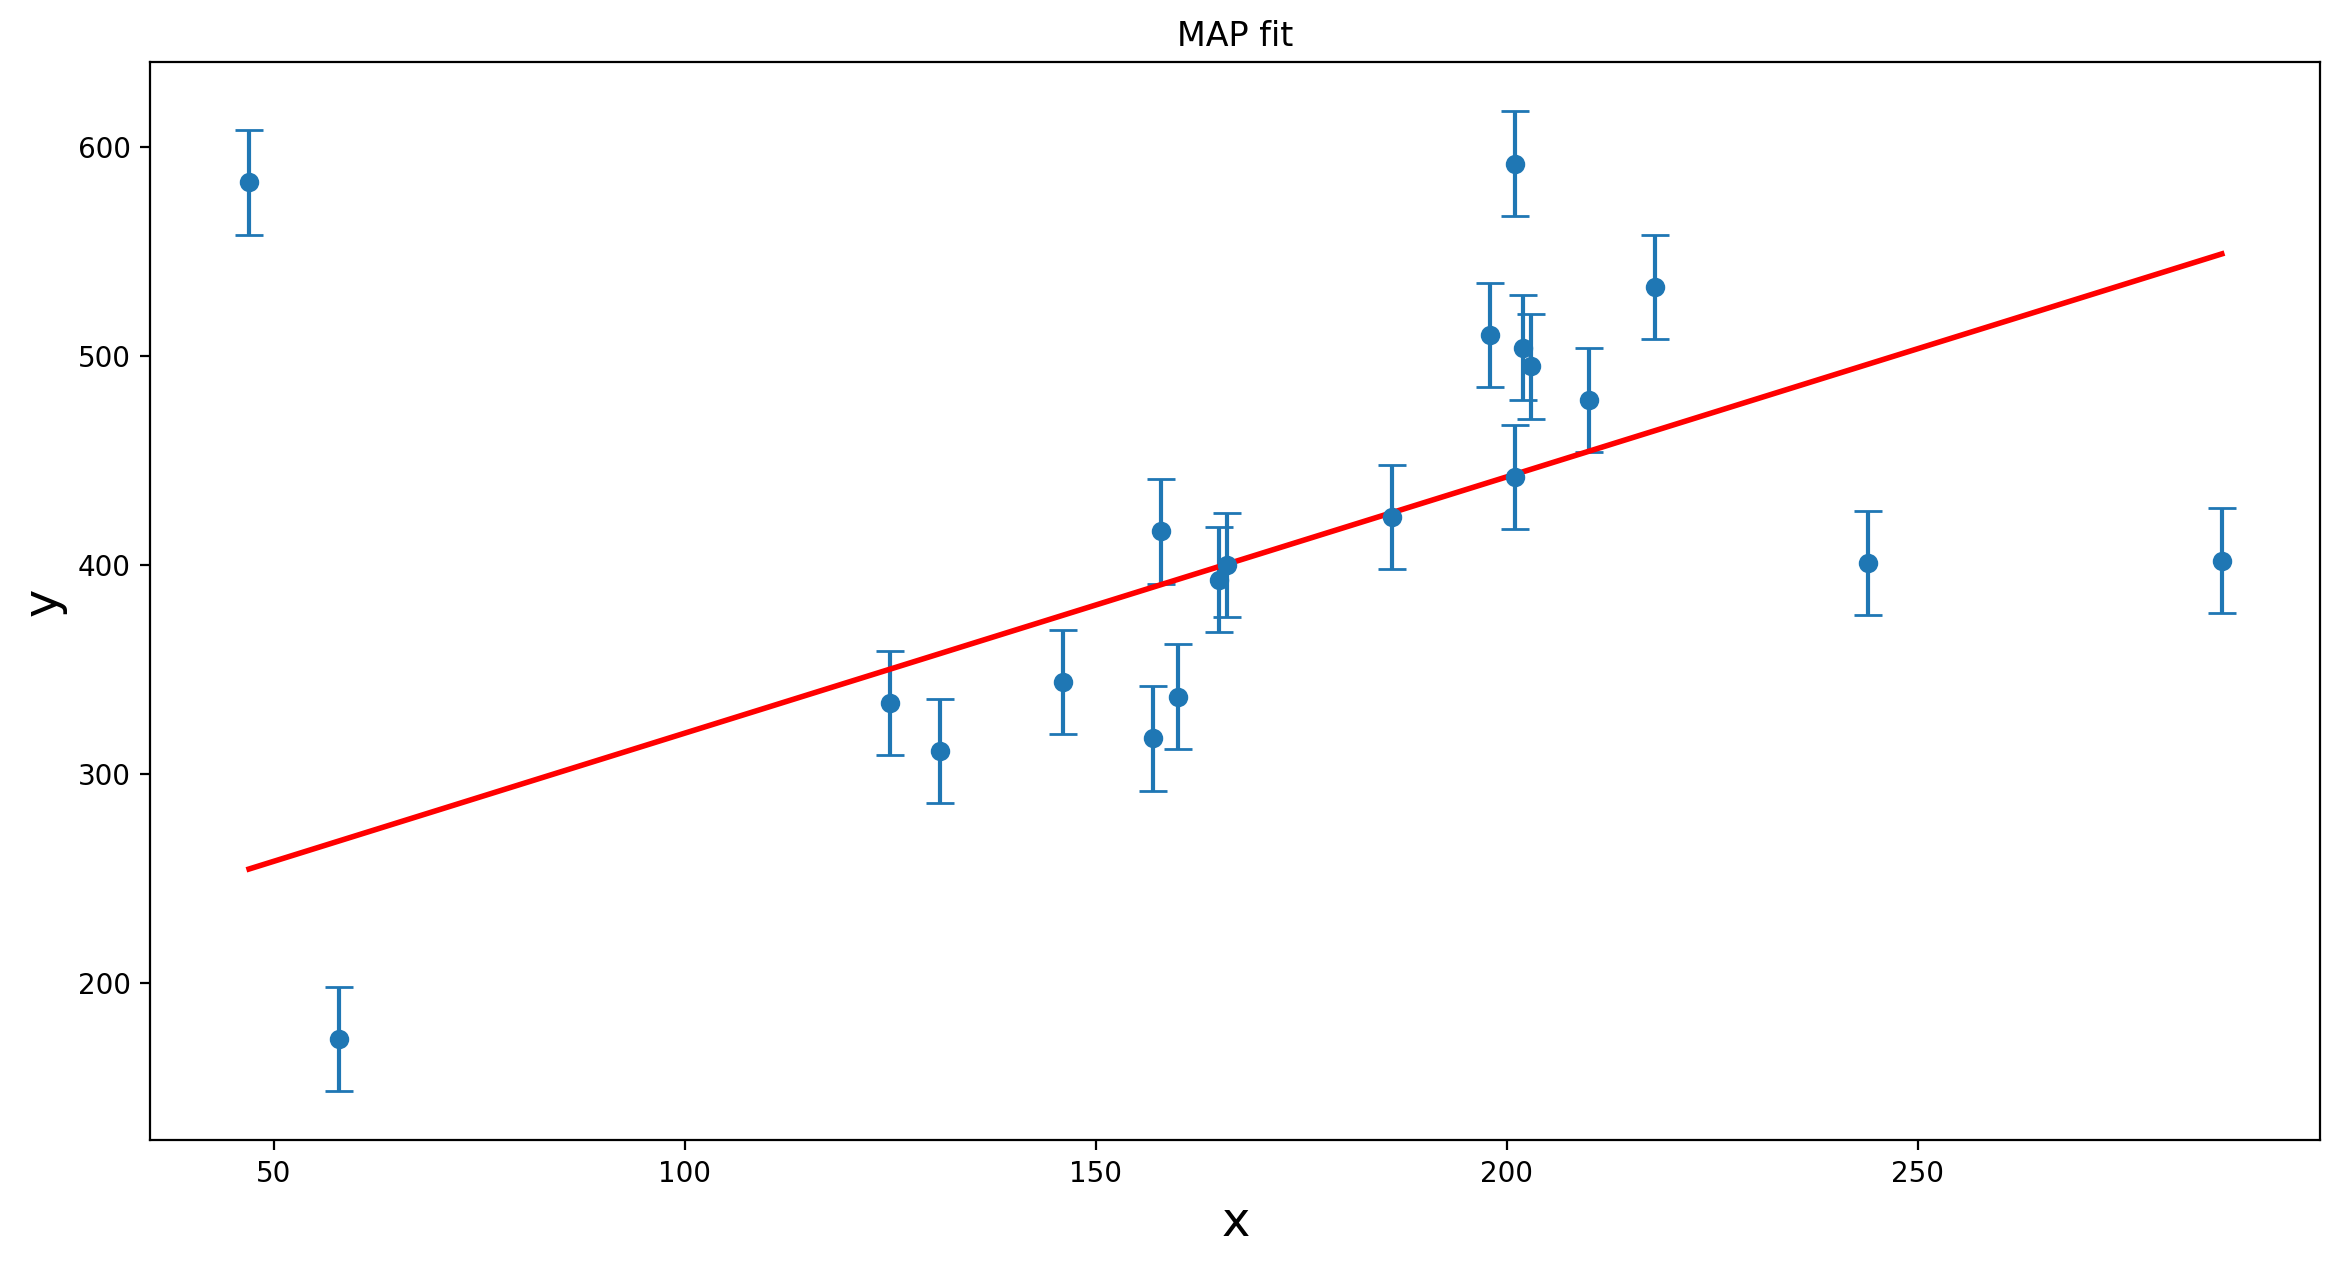

In [19]:
fig = plt.figure(figsize=(14, 7))
ax = plt.gca()

plot_fit(ax, w_map, hogg_x, hogg_y, sigma, title='MAP fit')

Is this fit convincing? How does it compare to OLS?

In [20]:
print(f"OLS:\n {w}")
print(f"Bayesian\n {mu_n}")

OLS:
 [[  0.63201154]
 [310.01720255]]
Bayesian
 [[  1.2265356]
 [196.8054129]]


This fit is definitely more convincing. The line fits better, although it is not perfect (probably due to outliers). The higher value of ($w$) was indeed anticipated.

### Uncertainty in our fit

There is a simple way to judge the uncertainty in our regression fits - we can draw many samples from the posterior over $\mathbf{w}$ and then plot them together.

Let's start by calculating the posterior again. For now we assume that response uncertainty is $\sigma = 25.0$.

In [21]:
sigma = 25.

mu_n, Sigma_n = bayes_lin_reg(mu_0, Sigma_0, sigma, hogg_x, hogg_y)
mu_n = np.squeeze(mu_n)

Now, generate 50 samples from the posterior. Store them in `w_samples_1`.

In [22]:
# raise Exception('Generate 50 samples from the posterior over w and store them in w_samples_1.')

w_samples_1 = mvn.rvs(mu_n, Sigma_n, 50)

Let's plot these samples.

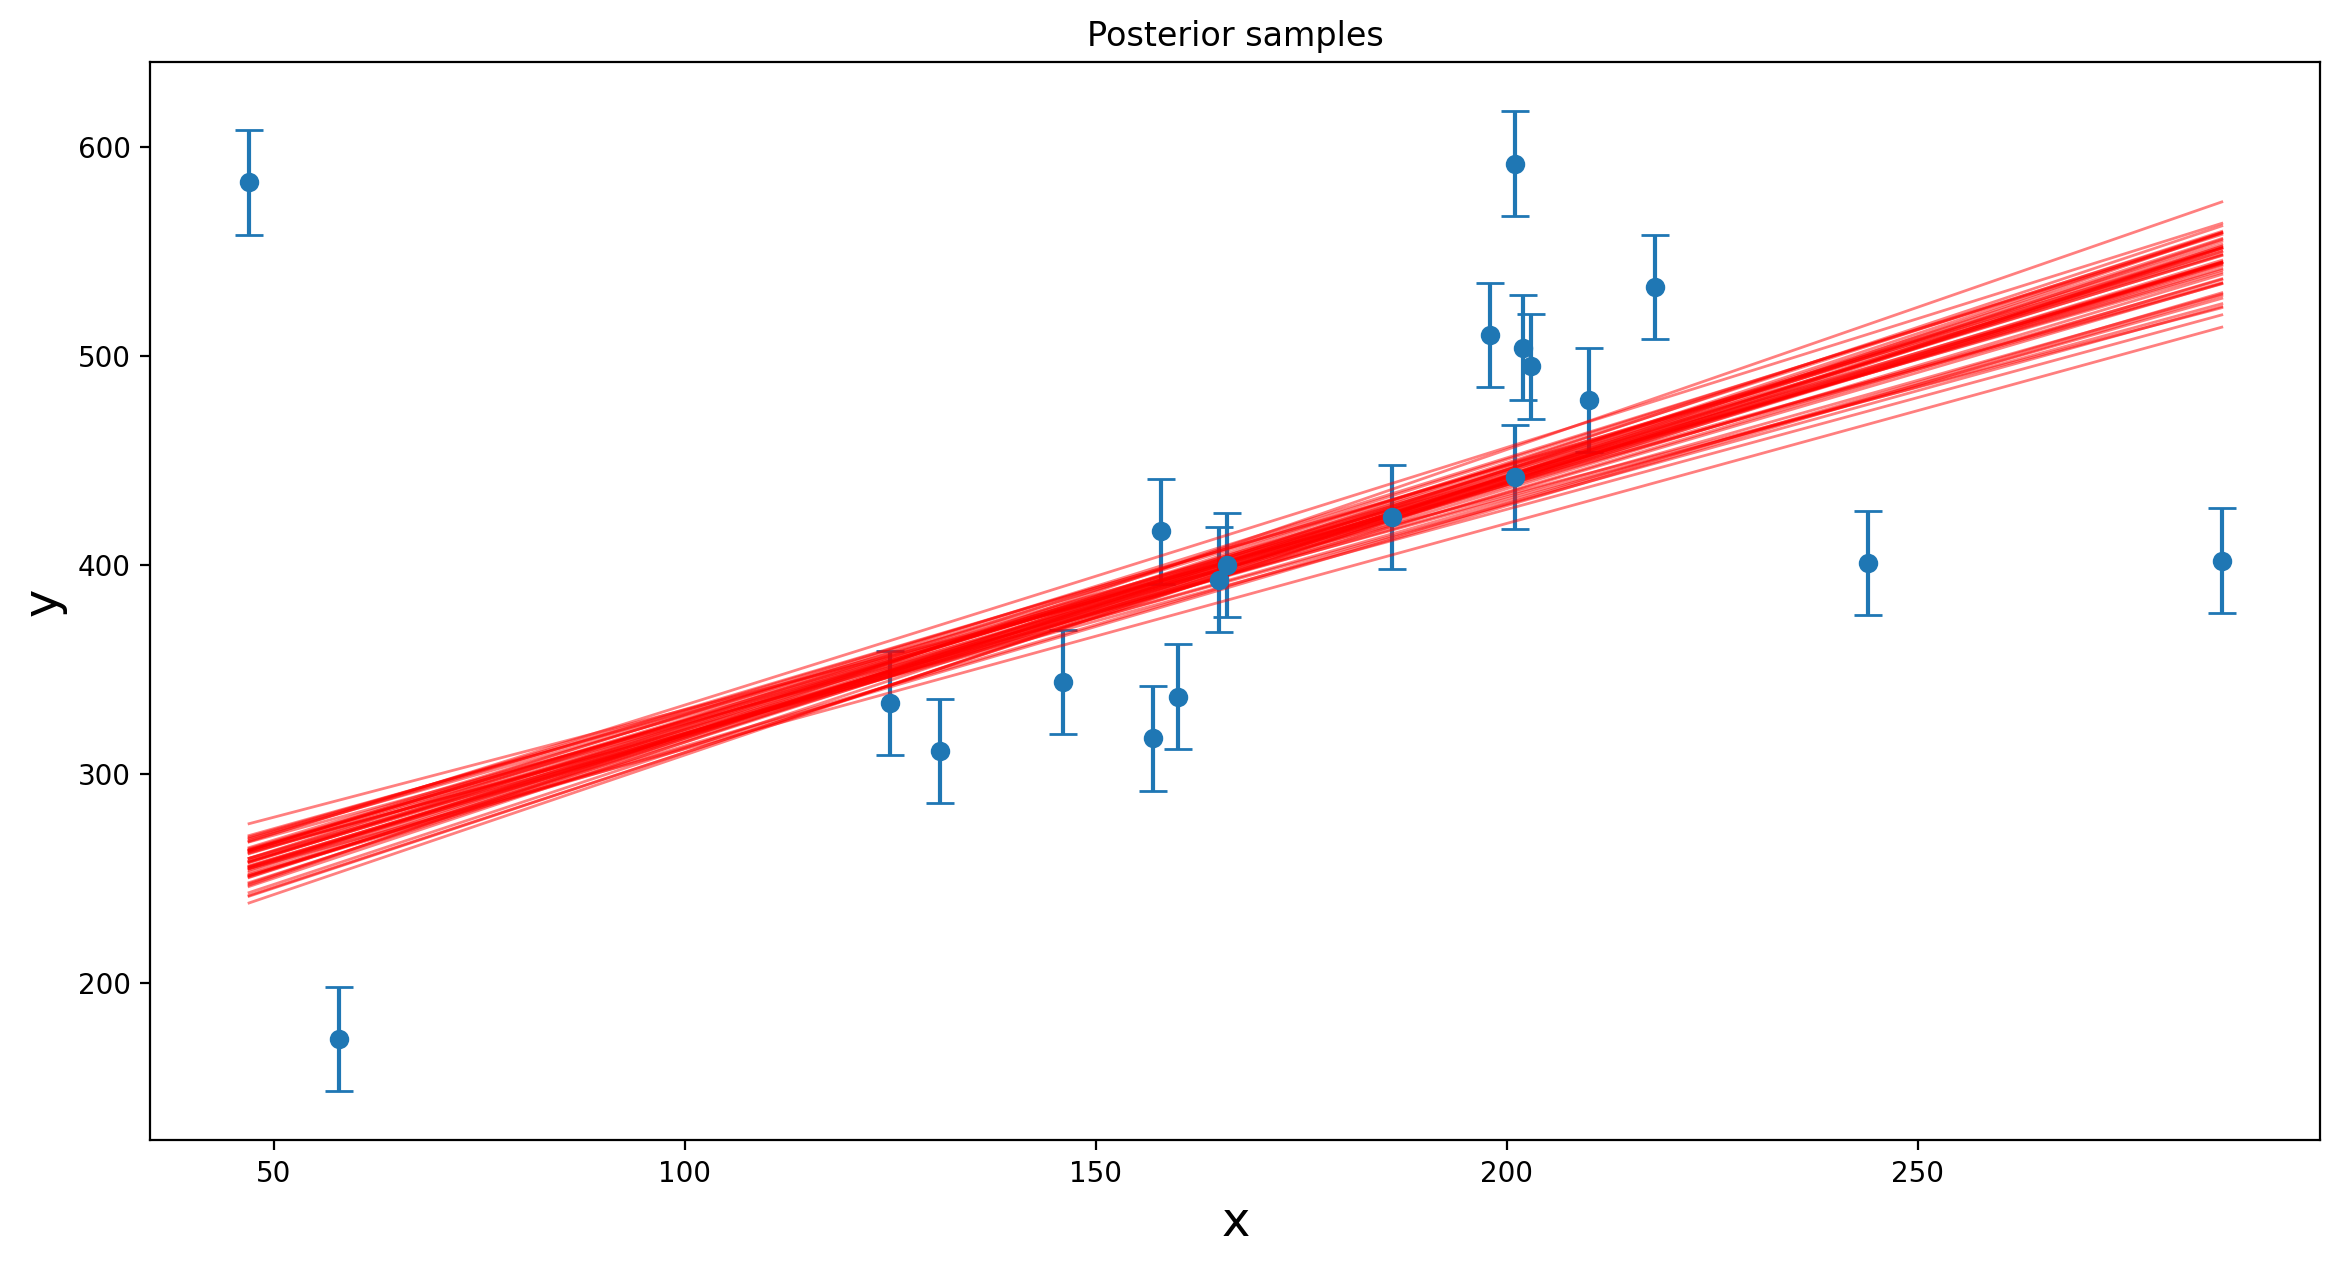

In [23]:
fig = plt.figure(figsize=(14, 7))
plot_posterior_samples(plt.gca(), w_samples_1, hogg_x, hogg_y, sigma, title='Posterior samples')

#### Mikrozadanko.

Na osi x - ile punktów weszło do regresji, na y - niepewność współczynnika kierunkowego.

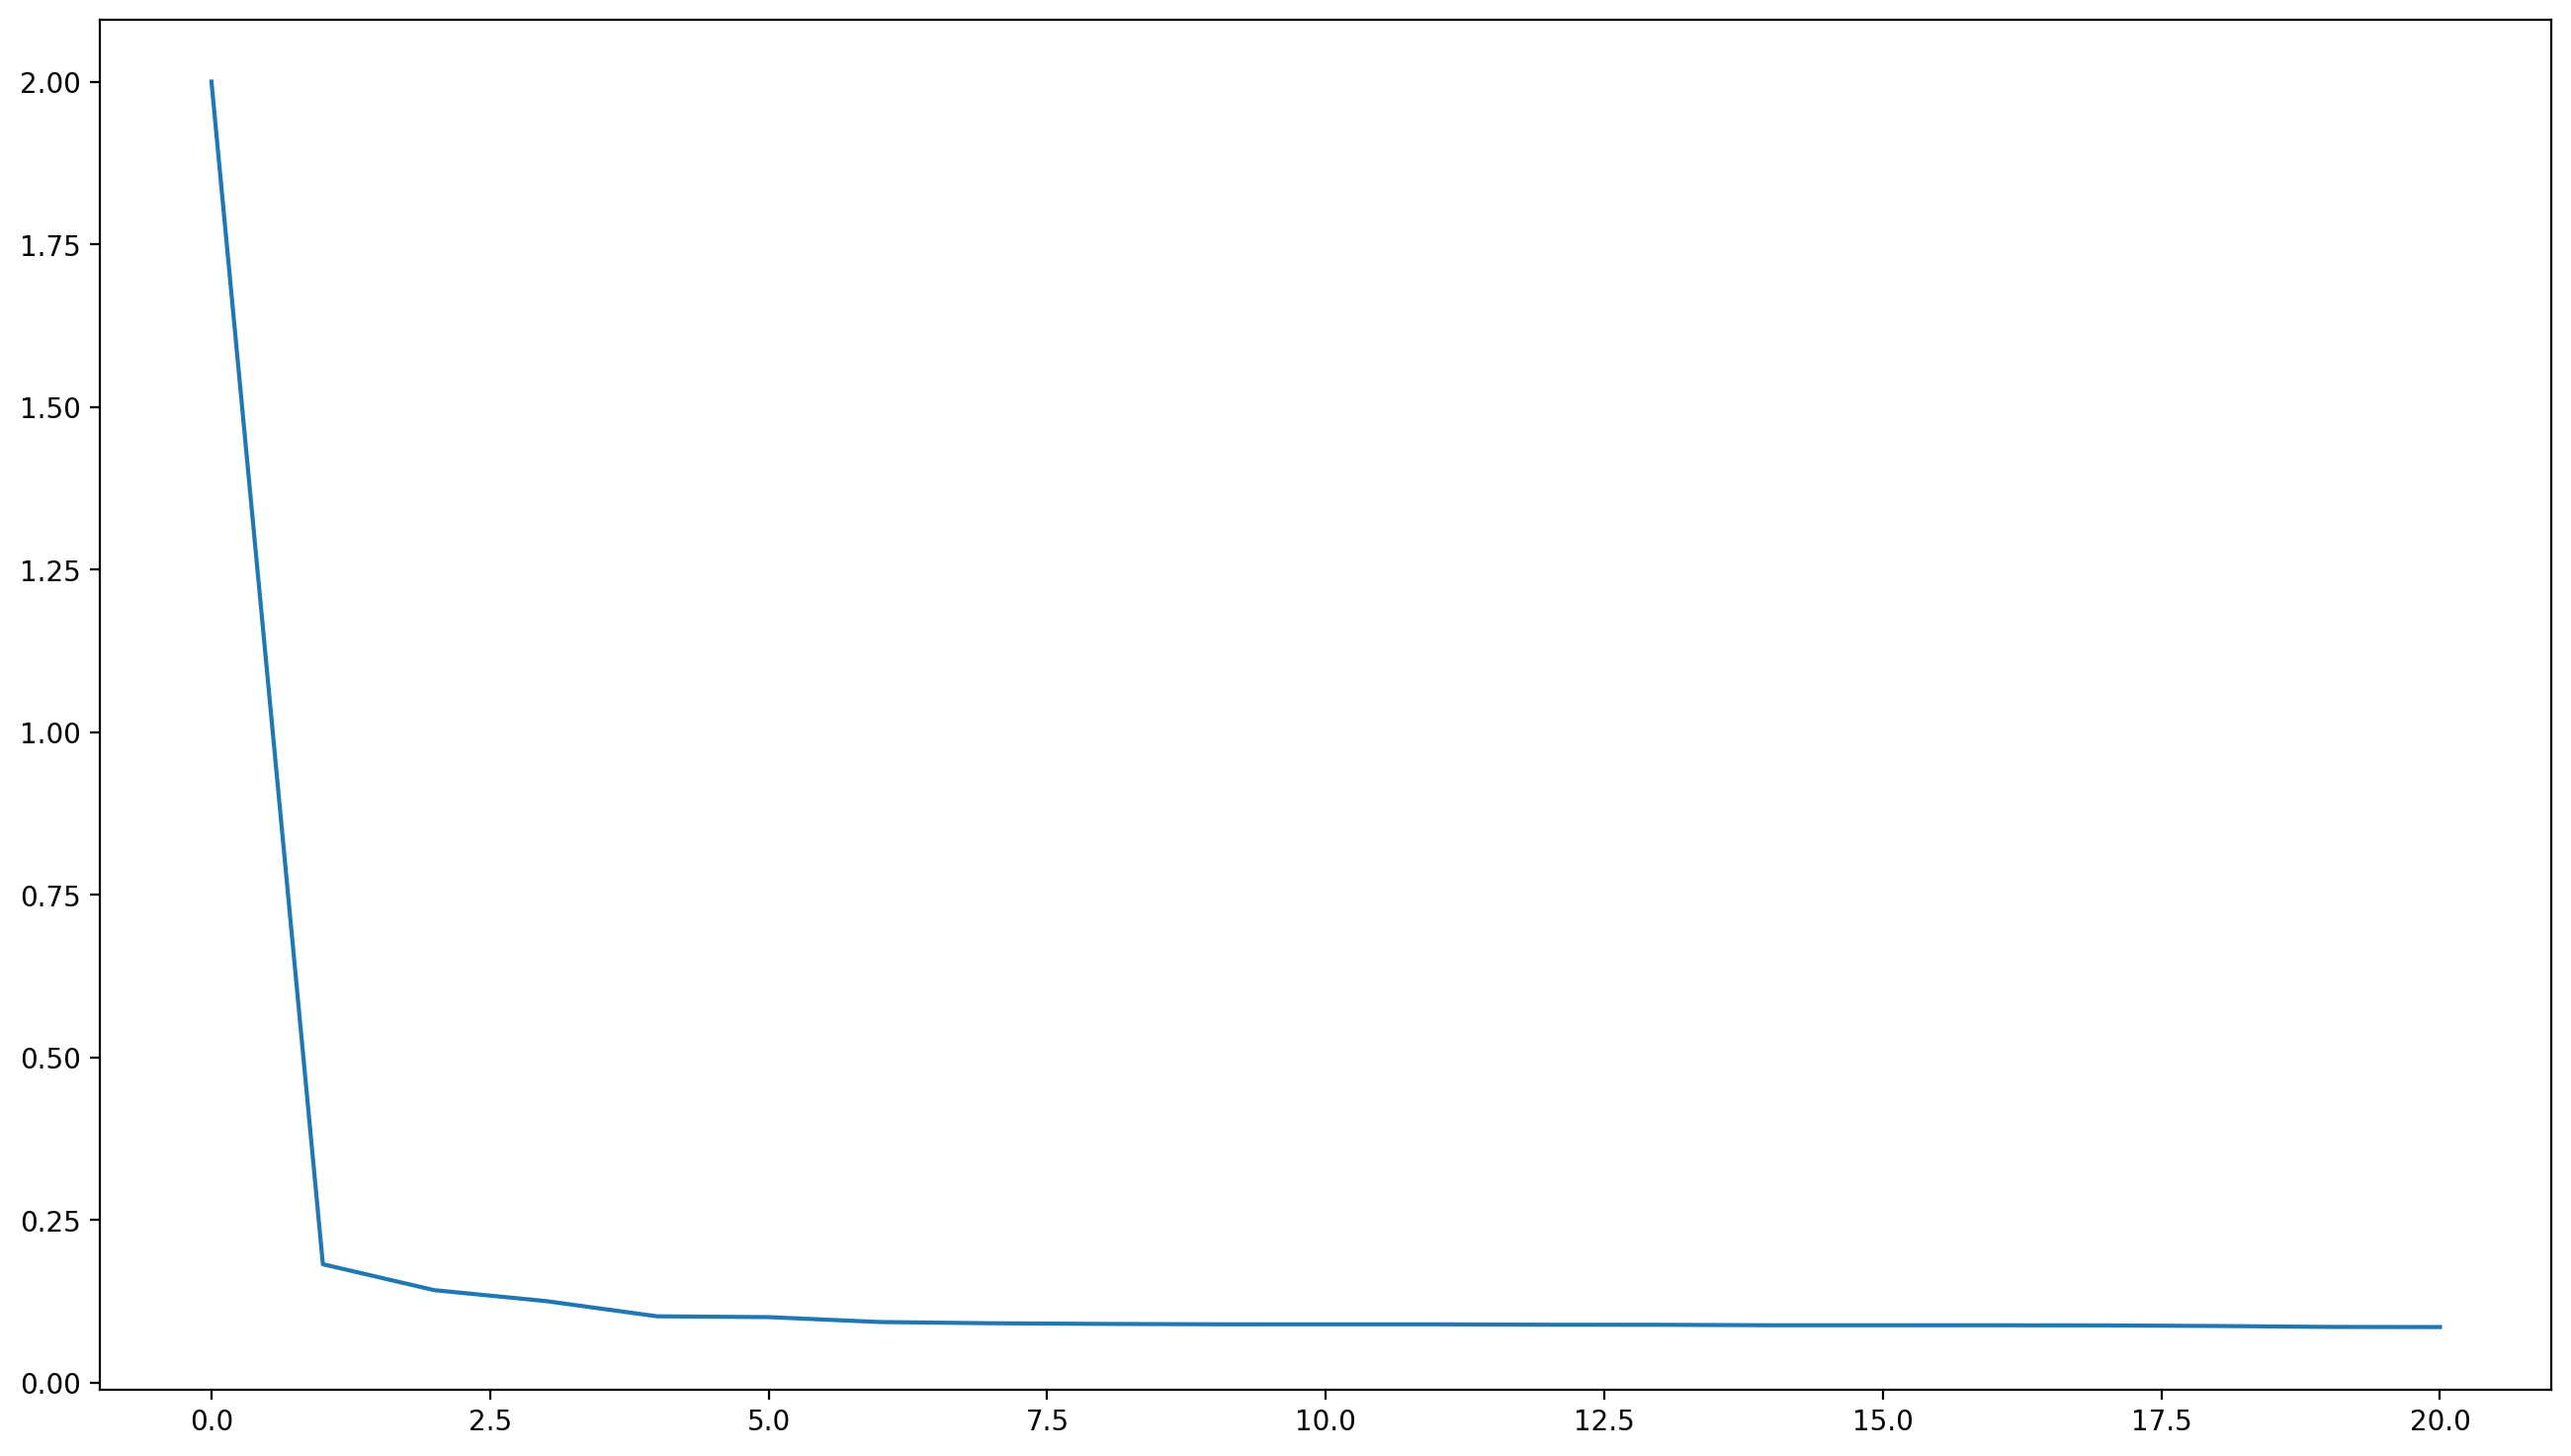

In [43]:
n = len(hogg_data)

mu_i, Sigma_i = mu_0, Sigma_0
points = list(range(n + 1))
uncertainties = [np.sqrt(Sigma_0[0, 0])]

for i in range(n):
    mu_i, Sigma_i = bayes_lin_reg(mu_i, Sigma_i, sigma, hogg_x[i : i + 1], hogg_y[i : i + 1])
    uncert_b = np.sqrt(Sigma_i[0, 0])
    uncertainties.append(uncert_b)

plt.plot(points, uncertainties)
    
    

---

What would happen if response uncertainty was $\sigma = 100.0$? Would this increase uncertainty in our fits?

In [25]:
sigma = 100.

mu_n, Sigma_n = bayes_lin_reg(mu_0, Sigma_0, sigma, hogg_x, hogg_y)
mu_n = np.squeeze(mu_n)

Generate 50 samples from this new posterior and store them in `w_samples_2`.

In [26]:
# raise Exception('Generate 50 samples from the new posterior over w and store them in w_samples_2.')

w_samples_2 = mvn.rvs(mu_n, Sigma_n, 50)

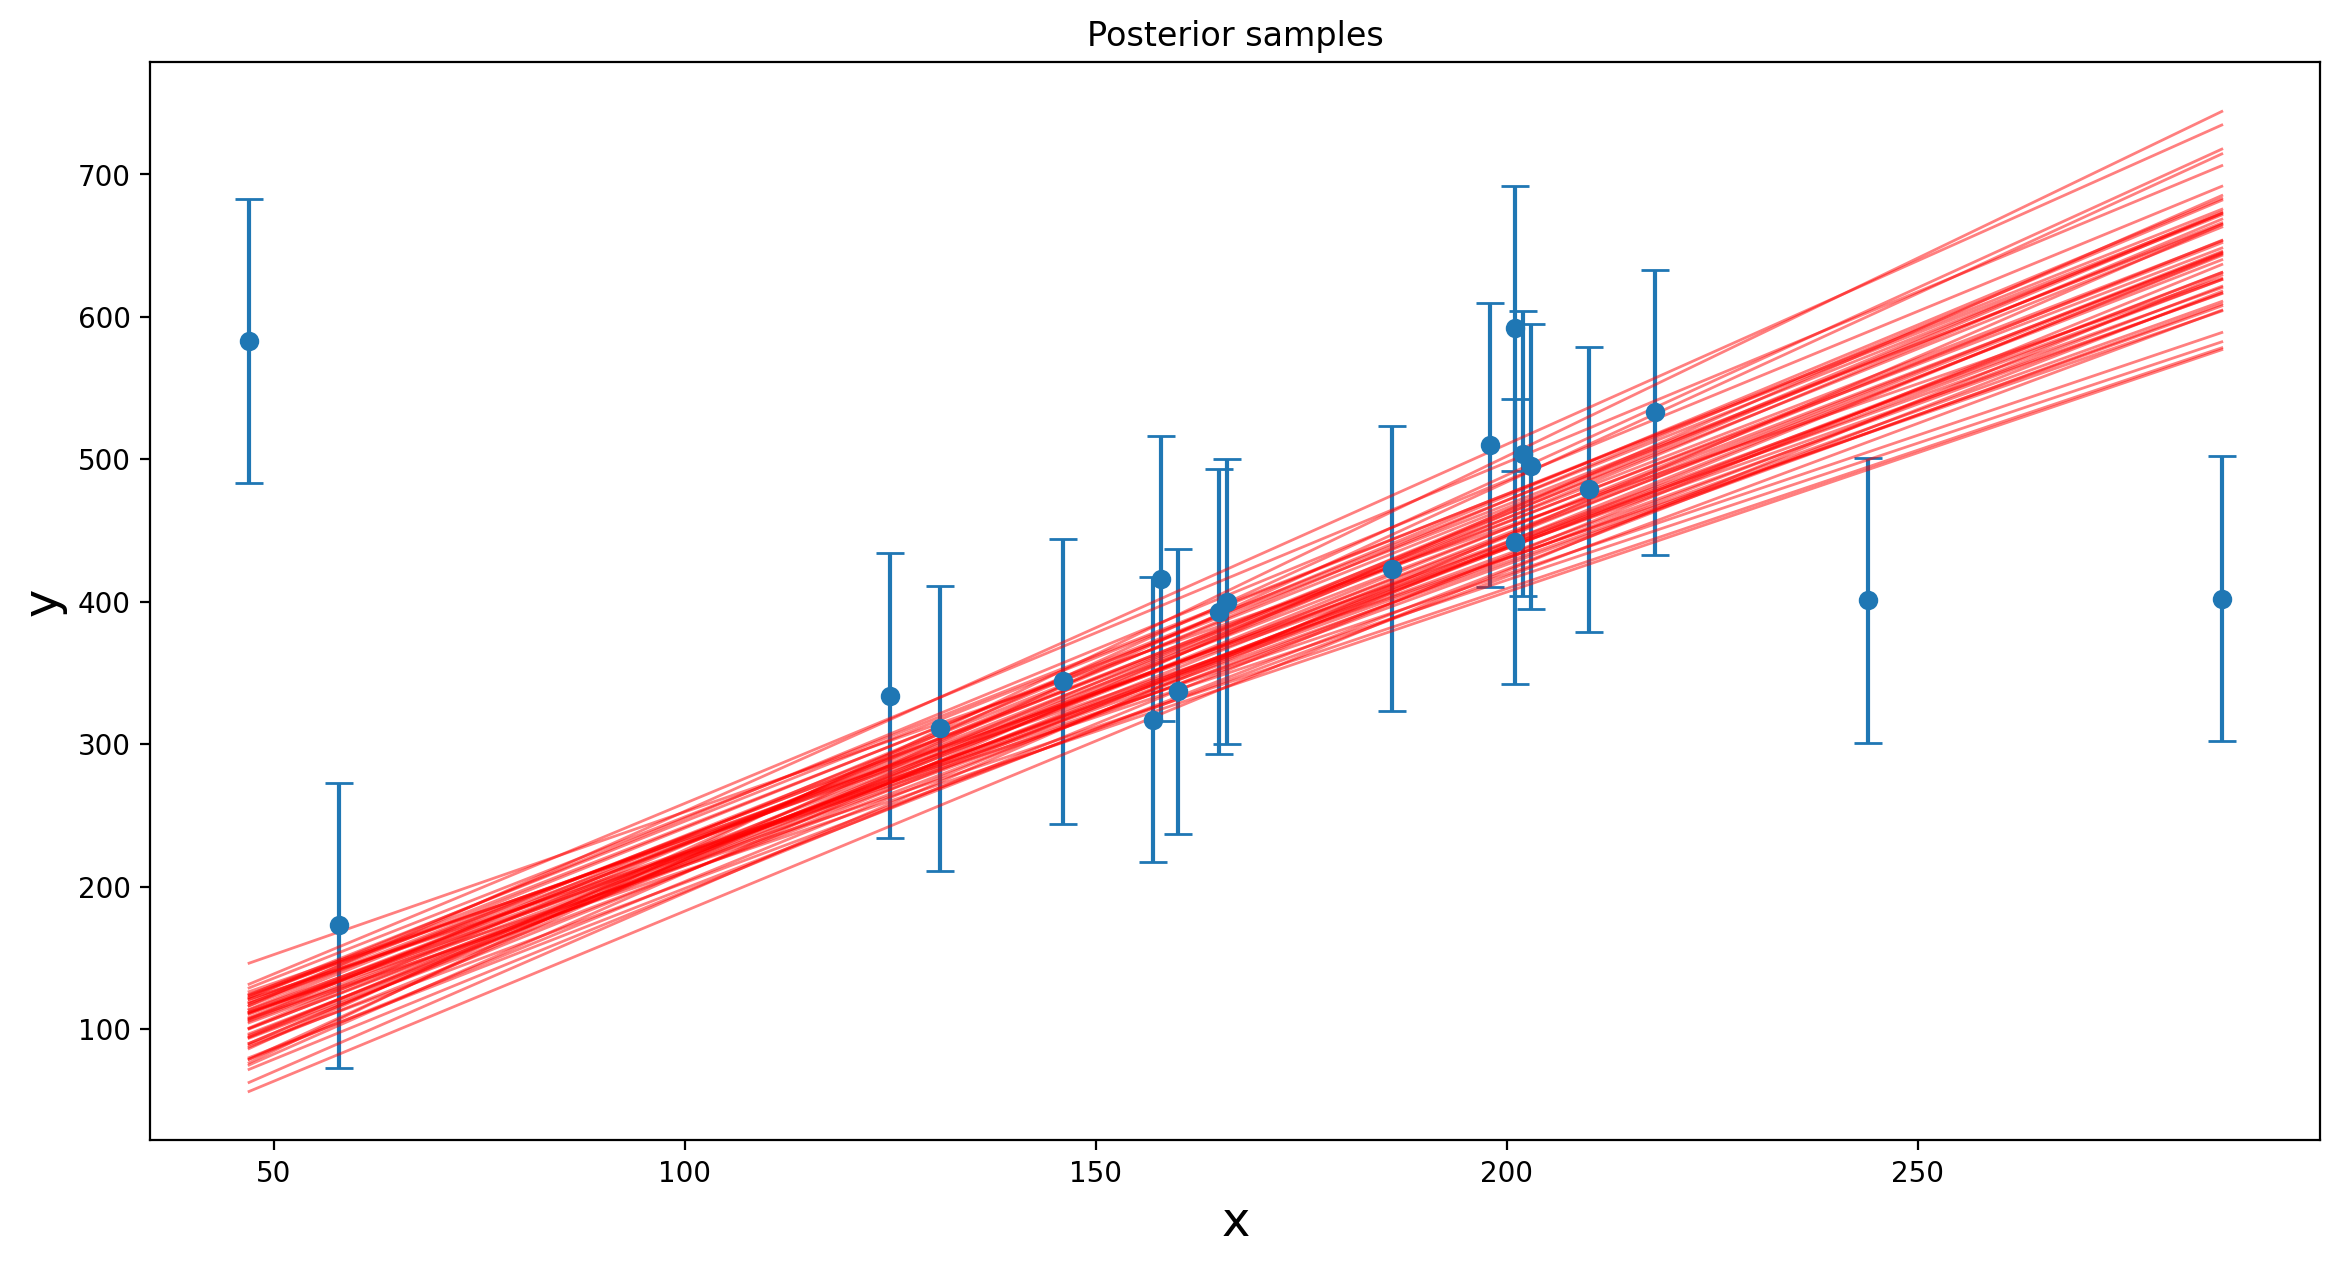

In [27]:
fig = plt.figure(figsize=(14, 7))
plot_posterior_samples(plt.gca(), w_samples_2, hogg_x, hogg_y, sigma, title='Posterior samples')

Did the fit uncertainty increase?

Yes, certainly.

### Posterior predictive

Finally, let's do some predictions for new (previously unobserved) data points.

In [28]:
test_x = np.array([[-150, 1],
                   [130, 1],
                   [280, 1]])

Implement `posterior_predictive` function, which:
- takes as an input:
    - posterior mean and covariance of the regression parameters $\mathbf{w}$
      (i.e. $\boldsymbol \mu_n$ and $\boldsymbol \Sigma_n$),
    - response uncertainty ($\sigma$ hyperparameter),
    - a vector of explanatory variables $\mathbf{x}$,
- and returns mean and standard deviation of the posterior predictive distribution
  $p(y \mid \mathbf{x}, \boldsymbol \mu_n, \boldsymbol \Sigma_n, \sigma)$<br>

This posterior predictive distribution describes our believs about the response $y$ predicted for the input $\mathbf{x}$.

In [29]:
def posterior_predictive(posterior_mu, posterior_Sigma, sigma, x):
    mu_y = posterior_mu.T @ x
    sigma_y = np.sqrt(sigma ** 2 + x.T @ posterior_Sigma @ x)

    return mu_y, sigma_y

Now, let's calculate posterior over $\mathbf{w}$ (assuming $\sigma = 25.0$)

In [30]:
sigma = 25.
mu_n, Sigma_n = bayes_lin_reg(mu_0, Sigma_0, sigma, hogg_x, hogg_y)

and use it to make predictions:

In [31]:
y_mu, y_sigma = np.empty(3), np.empty(3)
for idx, x in enumerate(test_x):
    y_mu[idx], y_sigma[idx] = posterior_predictive(mu_n, Sigma_n, sigma, x)

We can now plot our predictions. We plot:
  - expected value of $y$,
  - uncertainty about the predicted $y$, i.e. one standard deviation of $y$ (error bars),
  - mean posterior fit to the (training) data.

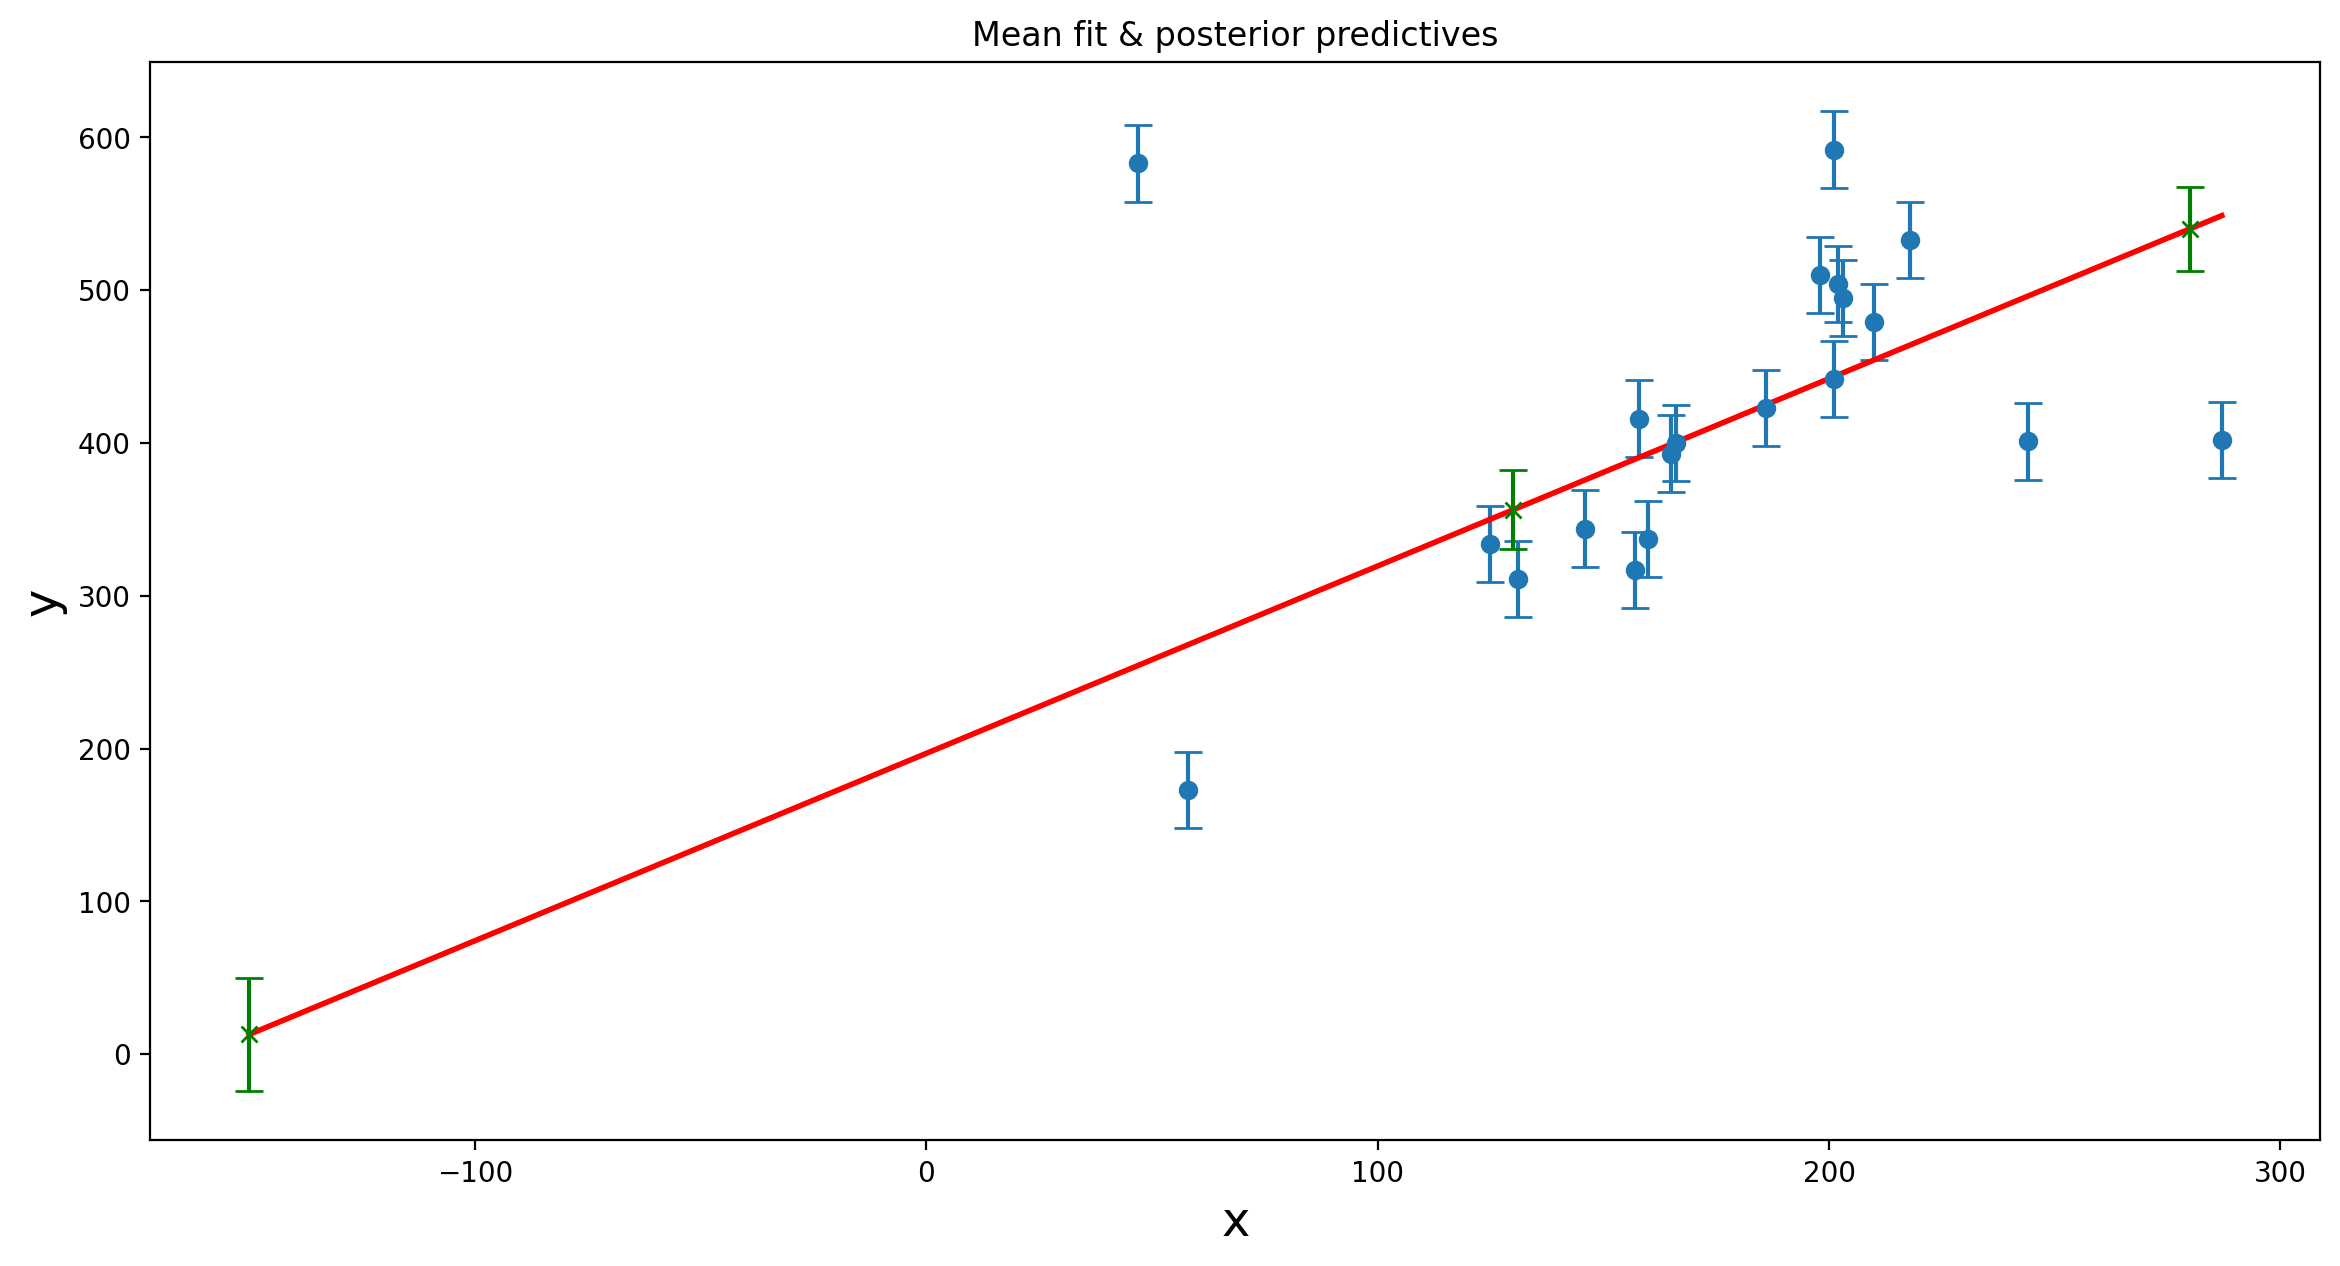

In [32]:
fig = plt.figure(figsize=(14, 7))
ax = plt.gca()
plot_fit(ax, mu_n, hogg_x, hogg_y, sigma,
         test_x=test_x, test_y=y_mu, test_ys=y_sigma,
         title='Mean fit & posterior predictives')

In [33]:
print(y_sigma)

[37.27424667 25.77813831 27.39473835]


Note that:
  - expected value of the predicted $y$ lies exactly on the posterior mean fit.
  - when we make predictions away from the data points our uncertainty about predicted value increases.